In [1]:
import scvelo as scv
import numpy as np
import pandas as pd

import scanpy as sc

In [2]:
adata = scv.datasets.pancreas()


In [3]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)


# Builtin HVG

In [ ]:
# adata.var['highly_variable_genes']

In [ ]:
# actual_mask = adata.var['highly_variable_genes'] == "True"

In [ ]:
# filtered = adata[:,actual_mask]

In [ ]:
# WHY IS VARIABILITY A MIXTURE OF BOOL STRINGS AND NANS? JFC
# filtered

# Foreign HVG

In [4]:
hvg = np.loadtxt("./ZPSGenes.tsv",dtype=str)
hvg.shape

(1352,)

In [5]:
filtered = adata[:,hvg]

### Let's just double check real quick if there was even minimal sanity when doing the hv selection

In [ ]:
sc.pp.highly_variable_genes(adata,n_top_genes=4004)
adata.var['highly_variable']

In [ ]:
sc_calls = adata.var_names[adata.var['highly_variable']]
foreign_calls = adata.var_names[actual_mask]

In [ ]:
np.sum(actual_mask.astype(dtype=int))

In [ ]:
len(set(sc_calls).intersection(set(foreign_calls)))

# Vignette Analysis

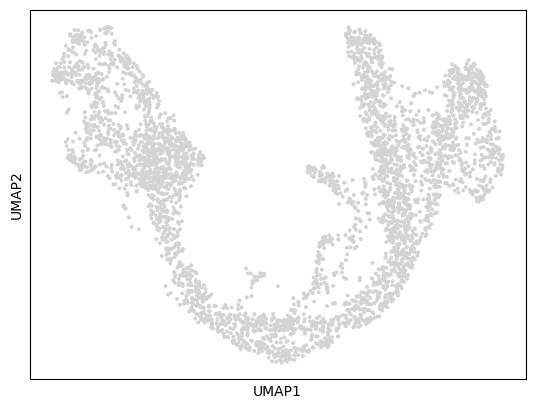

In [7]:
sc.pp.neighbors(filtered)
sc.tl.umap(filtered)
sc.pl.umap(filtered)

In [58]:
filtered.obsm['X_umap'] = u_t1

In [8]:
scv.pp.moments(filtered,n_neighbors=None,n_pcs=None)

Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [9]:
scv.tl.velocity(filtered)
scv.tl.velocity_graph(filtered)


computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


/Users/bbrener1/miniconda3/envs/forecaster/lib/python3.11/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


/Users/bbrener1/miniconda3/envs/forecaster/lib/python3.11/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/bbrener1/miniconda3/envs/forecaster/lib/python3.11/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/bbrener1/miniconda3/envs/forecaster/lib/python3.11/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/bbrener1/miniconda3/envs/fo

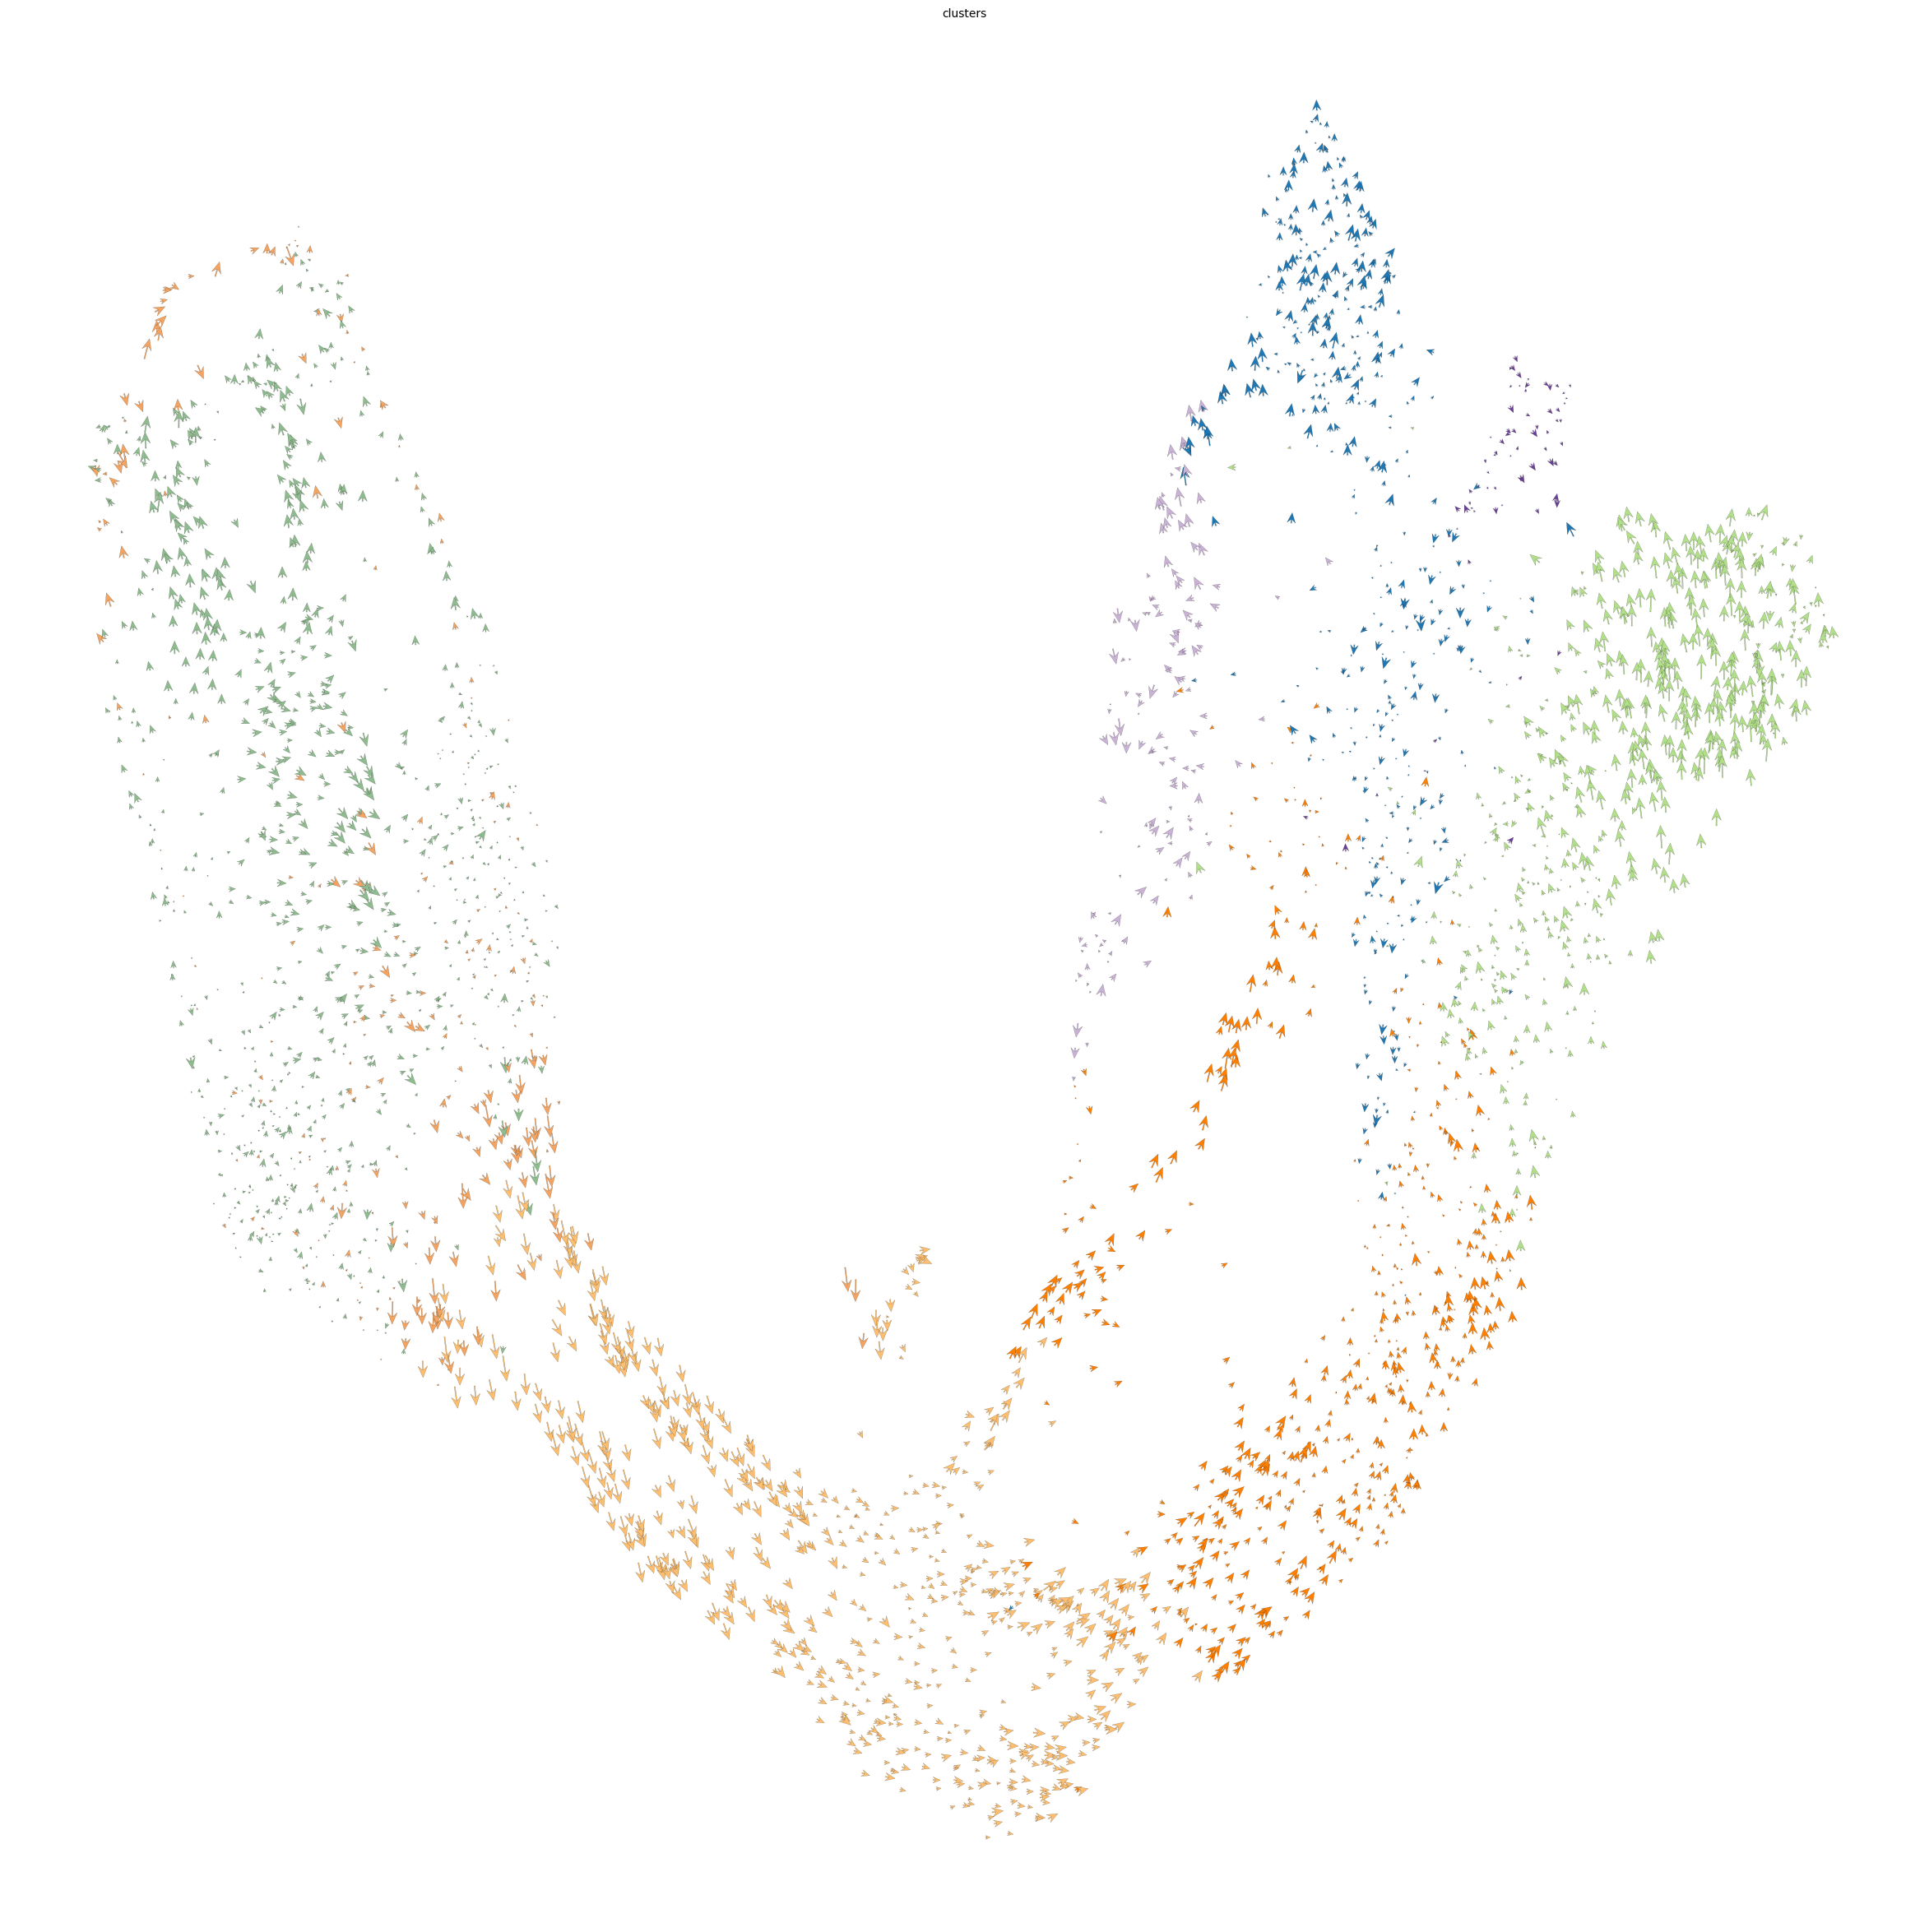

In [59]:
scv.pl.velocity_embedding(filtered,basis='umap',figsize=((30,30)))

In [ ]:
scv.pl.velocity_embedding_stream(filtered, density=5, basis='umap')

In [ ]:
sc.pl.umap(filtered,color="S_score")
sc.pl.umap(filtered,color="G2M_score")

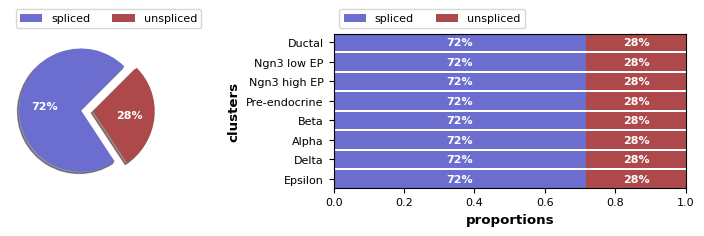

In [10]:
scv.pl.proportions(filtered)

# Foreign UMAP

In [ ]:
import matplotlib.pyplot as plt 

In [ ]:
from umap import UMAP
from sklearn.decomposition import PCA

In [ ]:
pca_model = PCA(n_components=50)
pca = pca_model.fit_transform(np.array(filtered.X.todense()))

umap_model = UMAP(n_neighbors=15,min_dist=0.5, spread=1.0, n_components=2, negative_sample_rate=5, random_state=0,metric='cosine')
u_t = umap_model.fit_transform(pca)

In [ ]:
plt.figure()
plt.scatter(*u_t.T,s=1)
# for i in range(0,3600,100):
#     plt.text(*u_t[i],f"{i}",)
plt.show()

In [ ]:
plt.figure()
plt.scatter(*filtered.obsm['X_umap'].T,s=1)
for i in range(1,3601,100):
    plt.text(*filtered.obsm['X_umap'][i],f"{i}")
plt.show()

In [ ]:
trajectories_1 = np.loadtxt("./trajectories_t1.tsv",dtype=float).T
trajectories_2 = np.loadtxt("./trajectories_t2.tsv",dtype=float).T
trajectories_3 = np.loadtxt("./trajectories_t3.tsv",dtype=float).T


In [ ]:
pca_transformed_trajectories_1 = pca_model.transform(trajectories_1)
pca_transformed_trajectories_2 = pca_model.transform(trajectories_2)
pca_transformed_trajectories_3 = pca_model.transform(trajectories_3)


embedded_1 = umap_model.transform(pca_transformed_trajectories_1)
embedded_2 = umap_model.transform(pca_transformed_trajectories_2)
embedded_3 = umap_model.transform(pca_transformed_trajectories_3)


In [ ]:
def arrow_deltas(t1,t2):
    x,y = t1
    dx,dy = t1 - t2
    return (x,y,dx,dy)
    
plt.figure(figsize=(10,8))
plt.scatter(*u_t.T,s=1)
for i in range(0,embedded_1.shape[0],30): 
    plt.arrow(*arrow_deltas(u_t[i],embedded_1[i]),color='green',head_width=.1,linewidth=.2)
    plt.arrow(*arrow_deltas(embedded_1[i],embedded_2[i]),color='red',head_width=.1,linewidth=.2)
    # plt.plot([u_t[i,0],embedded[i,0]],[u_t[i,1],embedded[i,1]],color='red')
plt.show()

In [ ]:
# trajectories = np.loadtxt("./trajectories_1700.tsv",dtype=float).T
# trajectories.shape

In [ ]:
pca_transformed_trajectories = pca_model.transform(trajectories)
pca_transformed_trajectories.shape

In [ ]:
embedded = umap_model.transform(pca_transformed_trajectories)
embedded.shape

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(*u_t.T,s=1)
for i in range(0,embedded.shape[0],10):
    x,y = u_t[i]
    dx,dy = (u_t[i] - embedded[i]) / 2
    plt.arrow(x,y,dx,dy,color='red',head_width=.1,linewidth=.2)
    # plt.plot([u_t[i,0],embedded[i,0]],[u_t[i,1],embedded[i,1]],color='red')
plt.show()

In [ ]:
# plt.figure()
# plt.scatter(*u_t.T,s=1)
# plt.plot(*embedded[:50].T,color='red')
# plt.show()

In [ ]:
trajectories = trajectories.reshape((1352,2,50))

In [ ]:
trajectories

# SCV Sanity Check

In [19]:
import matplotlib.pyplot as plt 
from umap import UMAP
from sklearn.decomposition import PCA

In [ ]:
t1 = np.array(filtered.layers['spliced'].todense())
t1 = np.log(t1 + 1) 

t2 = np.array(filtered.layers['unspliced'].todense())
t2 = np.log(t2 + 1) 


In [60]:
from umap import UMAP
from sklearn.decomposition import PCA

def arrow_deltas(time1,time2,damping=1):
    x,y = time1
    dx,dy = time2 - time1
    return (x,y,dx*damping,dy*damping)
    
def simple_sequence(time1,time2,highlight=[0,1],arrow_frequency=30):
    pca_model = PCA(n_components=50)
    pca_t1 = pca_model.fit_transform(time1)
    pca_t2 = pca_model.transform(time2)
    
    umap_model = UMAP(n_neighbors=15,min_dist=0.5, spread=1.0, n_components=2, negative_sample_rate=5, random_state=0,metric='cosine')
    u_t1 = umap_model.fit_transform(pca_t1)
    u_t2 = umap_model.transform(pca_t2)

    plt.figure(figsize=(10,8))
    plt.scatter(*u_t1.T,color='red',s=1)
    # plt.show()
    # plt.figure(figsize=(10,8))
    plt.scatter(*u_t2.T,color='blue',s=1)
    plt.show()

    # plt.figure(figsize=(10,8))
    # plt.scatter(*u_t1.T,s=1)
    # for i in highlight:
    #     plt.text(*u_t1[i],s=f"{i}")
    #     plt.text(*u_t2[i],s=f"{i}'")
    #     plt.arrow(*arrow_deltas(u_t1[i],u_t2[i]),color='red',head_width=.1,linewidth=.2)
    # for i in range(0,u_t1.shape[0],arrow_frequency): 
    #     plt.arrow(*arrow_deltas(u_t1[i],u_t2[i]),color='green',head_width=.1,linewidth=.2)
    # plt.show()

    return u_t1
    
    # plt.figure(figsize=(10,8))
    # plt.scatter(*pca_t1[:,:2].T,s=1)
    # for i in highlight:
    #     plt.text(*pca_t1[i,:2],s=f"{i}")
    # for i in range(0,pca_t1[:,:2].shape[0],arrow_frequency): 
    #     plt.arrow(*arrow_deltas(pca_t1[i,:2],pca_t2[i,:2],damping=1),color='green',head_width=.1,linewidth=.2)
    # plt.show()

# Let's Sanity-Check scVelo Velocities

In [43]:
t1 = np.array(filtered.X.copy().todense())

# # Is this in log space?
v = np.array(filtered.layers['velocity'])
v = np.log1p(np.abs(v)) * np.sign(v)

t2 = t1+(v/5)

# clip negatives

t2[t2 < 0] = 0

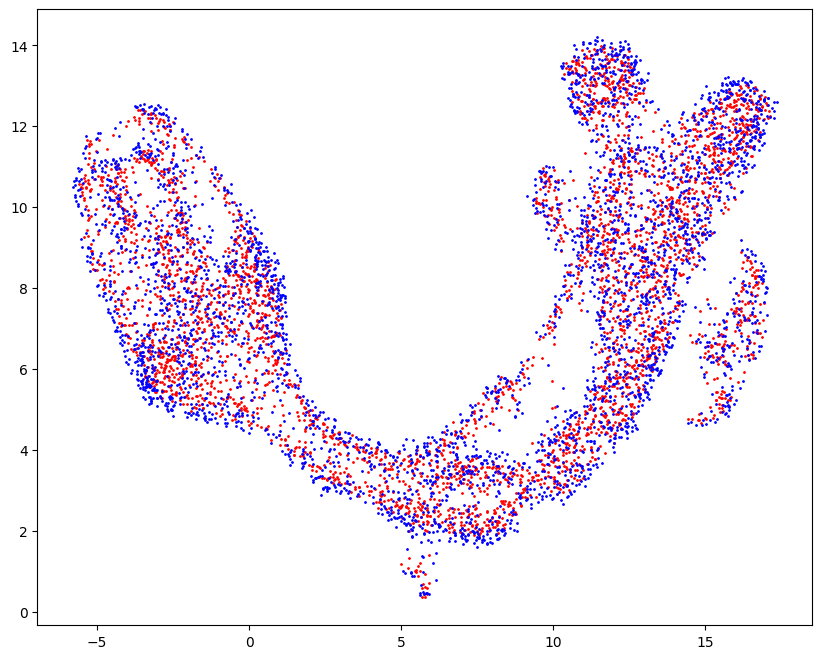

In [61]:
u_t1 = simple_sequence(t1,t2,arrow_frequency=10,highlight=[20])

In [ ]:
plt.figure()
plt.hist(t1[1],bins=50)
plt.show()

In [13]:
vg = np.array(filtered.uns['velocity_graph'].todense())

In [14]:
index_most_likely = np.argmax(vg,axis=1)
most_likely_t2 = np.array(filtered.X[index_most_likely].todense())

In [15]:
damped = (t1 * .8) + (most_likely_t2 * .2) 

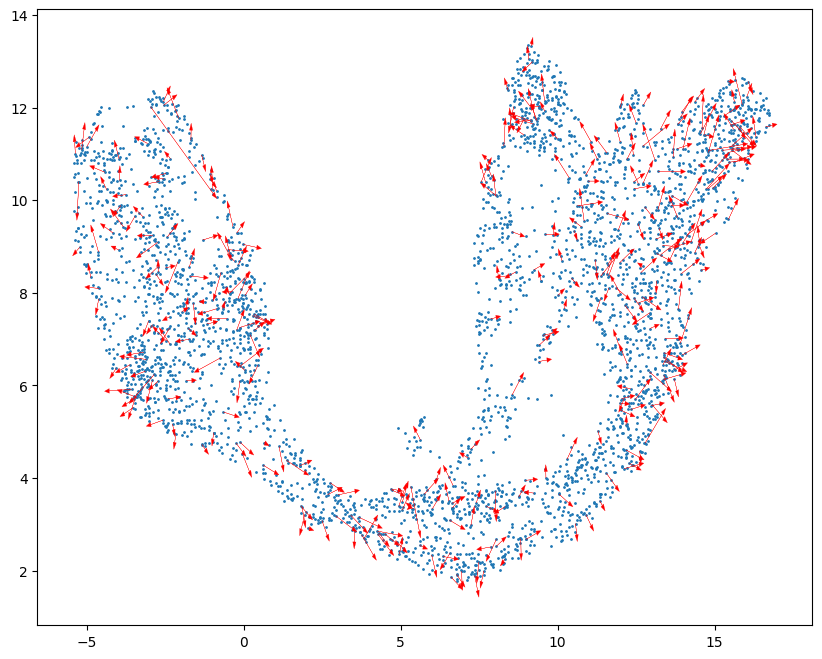

In [34]:
simple_sequence(t1,damped,highlight=[],arrow_frequency=10)

In [ ]:
simple_sequence(t1,most_likely_t2,highlight=[100,index_most_likely[100]],arrow_frequency=100)

In [ ]:
index_most_likely[0]

In [37]:
most_likely_n5 = np.argsort(vg,axis=1)[:,-5:]

In [39]:
trajectories = []
for best in most_likely_n5:
    trajectories.append(np.mean(t1[best],axis=0))
trajectories = np.array(trajectories)
trajectories.shape

(3696, 1352)

In [40]:
damped = (t1 * .8) + (trajectories * .2) 

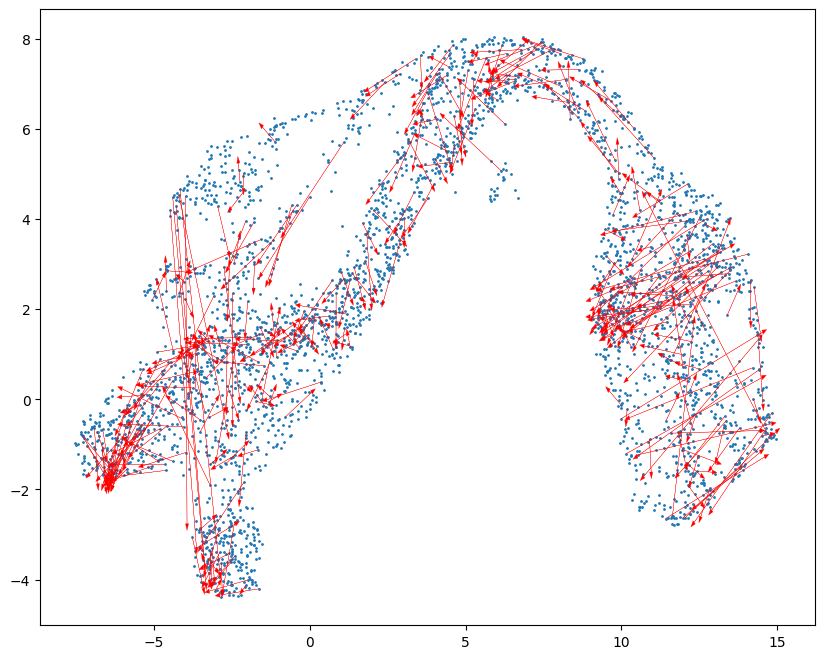

In [42]:
simple_sequence(t1,trajectories,highlight=[],arrow_frequency=10)